In [1]:
import numpy as np
from pandas import read_excel
from matplotlib import pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import pandas as pd
import os
%matplotlib inline

In [2]:
os.chdir("C:\\Users\\satish\\Desktop")

In [3]:
series = read_excel("TSF_data.xlsx", sheet_name = "ARIMA")

In [4]:
series.head()

,qtr,t,price
0,10 Q1,1,8
1,10 Q2,2,12
2,10 Q3,3,6
3,10 Q4,4,25
4,11 Q1,5,16


In [5]:
series.describe()

,t,price
count,20.00000,20.000000
mean,10.50000,26.450000
std,5.91608,12.853322
min,1.00000,6.000000
25%,5.75000,15.750000
50%,10.50000,26.000000
75%,15.25000,36.250000
max,20.00000,50.000000


<AxesSubplot:xlabel='t'>

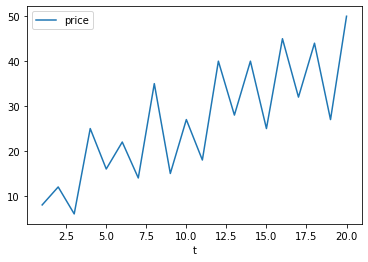

In [6]:
series.plot.line(x='t', y='price')

## Check stationarity using AD fuller test

In [7]:
from statsmodels.tsa.stattools import adfuller


In [8]:
    def adfuller_test(sales):
        result = adfuller(sales)
        labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations']

        for value,label in zip(result,labels):
            print(label+' : '+str(value) )

        if result[1] <= 0.05:
            print("Strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary")
        else:
            print("Weak evidence against null hypothesis, indicating it is non-stationary ")

    adfuller_test(series['price'])

ADF Test Statistic : -1.3116724107916997
p-value : 0.6238153965281679
#Lags Used : 8
Number of Observations : 11
Weak evidence against null hypothesis, indicating it is non-stationary 


In [19]:
series['Price First Difference'] = series['price'] - series['price'].shift(1)
series['Price Second Difference'] = series['price'] - series['price'].shift(2)

series.head()

,qtr,t,price,Price First Difference,forecast,Price Second Difference
0,10 Q1,1,8,NaN,NaN,NaN
1,10 Q2,2,12,4.0,NaN,NaN
2,10 Q3,3,6,-6.0,1.709023,-2.0
3,10 Q4,4,25,19.0,1.709023,13.0
4,11 Q1,5,16,-9.0,1.709023,10.0


In [20]:
# Again testing if data is stationary
adfuller_test(series['Price First Difference'].dropna())

ADF Test Statistic : -3.6608645821858024
p-value : 0.004698543719736368
#Lags Used : 7
Number of Observations : 11
Strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary


In [21]:
# Again testing if data is stationary
adfuller_test(series['Price Second Difference'].dropna())

ADF Test Statistic : -2.0898243319878236
p-value : 0.24862592575841086
#Lags Used : 7
Number of Observations : 10
Weak evidence against null hypothesis, indicating it is non-stationary 


<AxesSubplot:>

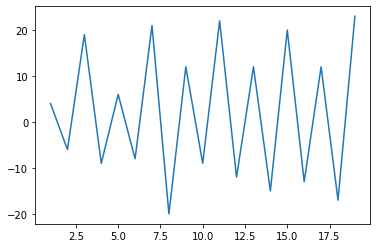

In [11]:
series['Price First Difference'].plot()

### Autocorrelation is a calculation of the correlation of the time series observations with values of the same series, but at previous times. The time steps at those previous times are referred to as lags

### A partial autocorrelation is a summary of the relationship between an observation in a time series with observations at prior time steps with the relationships of intervening observations removed and the indirect correlations are removed.
### The partial autocorrelation at lag k is the correlation that results after removing the effect of any correlations due to the terms at shorter lags.

C:\Users\satish\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


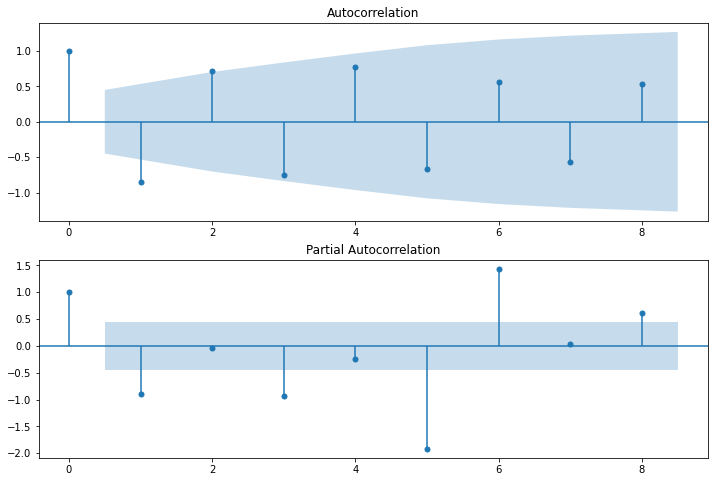

In [30]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)

fig = sm.graphics.tsa.plot_acf(series['Price First Difference'].dropna(),lags=8,ax=ax1)
ax2 = fig.add_subplot(212)

fig = sm.graphics.tsa.plot_pacf(series['Price First Difference'].dropna(),lags=8,ax=ax2)

### From this we can observe that acf shuts down after lag 2 (q) and pacf only after  (p), hence these can be potential parameters for arima

## Auto arima

In [14]:
from pmdarima import auto_arima

# Fit auto_arima function 
stepwise_fit = auto_arima(series['price'], start_p = 1, start_q = 1,
                          max_p = 4, max_q = 4, m = 4,
                          start_P = 0, seasonal = True,
                          d = 1, D = 1, trace = True,
                          error_action ='ignore',   # we don't want to know if an order does not work
                          suppress_warnings = True,  # we don't want convergence warnings
                          stepwise = True) 

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[4]             : AIC=inf, Time=0.34 sec
 ARIMA(0,1,0)(0,1,0)[4]             : AIC=88.944, Time=0.04 sec
 ARIMA(1,1,0)(1,1,0)[4]             : AIC=89.237, Time=0.07 sec
 ARIMA(0,1,1)(0,1,1)[4]             : AIC=88.162, Time=0.12 sec
 ARIMA(0,1,1)(0,1,0)[4]             : AIC=89.235, Time=0.11 sec
 ARIMA(0,1,1)(1,1,1)[4]             : AIC=inf, Time=0.39 sec
 ARIMA(0,1,1)(0,1,2)[4]             : AIC=inf, Time=0.28 sec
 ARIMA(0,1,1)(1,1,0)[4]             : AIC=inf, Time=0.17 sec
 ARIMA(0,1,1)(1,1,2)[4]             : AIC=inf, Time=0.38 sec
 ARIMA(0,1,0)(0,1,1)[4]             : AIC=89.960, Time=0.06 sec
 ARIMA(0,1,2)(0,1,1)[4]             : AIC=inf, Time=0.34 sec
 ARIMA(1,1,0)(0,1,1)[4]             : AIC=89.455, Time=0.06 sec
 ARIMA(1,1,2)(0,1,1)[4]             : AIC=inf, Time=0.35 sec
 ARIMA(0,1,1)(0,1,1)[4] intercept   : AIC=inf, Time=0.26 sec

Best model:  ARIMA(0,1,1)(0,1,1)[4]          
Total fit time: 2.955 seconds


### from this we can see that the best recommended values of (p,d,q) = (0,1,1) and seasonality = (0,1,1) with 4 periods in season

## ARIMA model 

In [16]:

from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(series['price'], order=(0,1,1))
model_fit=model.fit()
model_fit.summary()

C:\Users\satish\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.price   No. Observations:                   19
Model:                 ARIMA(0, 1, 1)   Log Likelihood                 -67.815
Method:                       css-mle   S.D. of innovations              7.936
Date:                Tue, 03 Aug 2021   AIC                            141.629
Time:                        02:43:54   BIC                            144.463
Sample:                             1   HQIC                           142.109
                                                                              
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             1.7090      0.308      5.553      0.000       1.106       2.312
ma.L1.D.price    -1.0000      0.131     -7.657      0.000      -1.256      -0.744
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1            1.0000           +0.0000j            1.0000            0.0000
-----------------------------------------------------------------------------
"""

<AxesSubplot:>

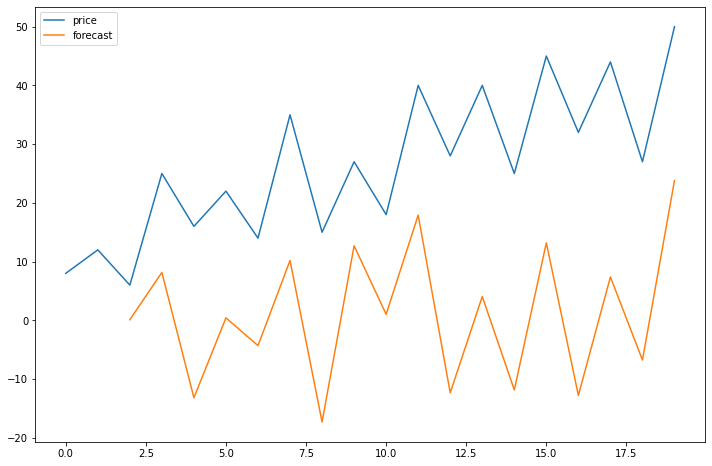

In [29]:
series['forecast'] = model_fit.predict()
series[['price','forecast']].plot(figsize=(12,8))

In [23]:

from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(series['price'], order=(0,1,2))
model_fit=model.fit()
model_fit.summary()

C:\Users\satish\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\satish\anaconda3\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  wa

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.price   No. Observations:                   19
Model:                 ARIMA(0, 1, 2)   Log Likelihood                 -61.826
Method:                       css-mle   S.D. of innovations              4.858
Date:                Tue, 03 Aug 2021   AIC                            131.651
Time:                        02:59:45   BIC                            135.429
Sample:                             1   HQIC                           132.291
                                                                              
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             1.6624      0.065     25.576      0.000       1.535       1.790
ma.L1.D.price    -1.9989      0.292     -6.840      0.000      -2.572      -1.426
ma.L2.D.price     0.9989      0.269      3.716      0.000       0.472       1.526
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1            1.0001           +0.0000j            1.0001            0.0000
MA.2            1.0010           +0.0000j            1.0010            0.0000
-----------------------------------------------------------------------------
"""

<AxesSubplot:>

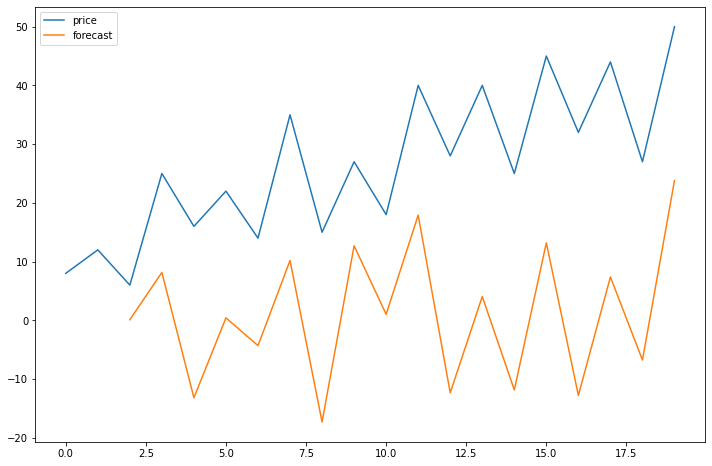

In [28]:
series['forecast'] = model_fit.predict()
series[['price','forecast']].plot(figsize=(12,8))

We can see manual arima params were better than those of auto arima

### We can see that the coefficients of first order difference are significant but the model doesn't give a good fit for the forecast price

## Try SARIMAX

In [25]:
import statsmodels.api as sm
model = sm.tsa.statespace.SARIMAX(series['price'],order=(0, 1, 2),seasonal_order = (0,1,1,4))
results = model.fit()
results.summary()

C:\Users\satish\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                               price   No. Observations:                   20
Model:             SARIMAX(0, 1, 2)x(0, 1, [1], 4)   Log Likelihood                 -40.754
Date:                             Tue, 03 Aug 2021   AIC                             89.509
Time:                                     03:01:40   BIC                             92.341
Sample:                                          0   HQIC                            89.479
                                              - 20                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.7913    134.439     -0.006      0.995    -264.286     262.704
ma.L2         -0.2076     28.258     -0.007      0.994     -55.591      55.176
ma.S.L4       -0.3676      0.415     -0.886      0.375      -1.181       0.445
sigma2        10.5350   1415.176      0.007      0.994   -2763.160    2784.230
===================================================================================
Ljung-Box (L1) (Q):                   0.12   Jarque-Bera (JB):                 1.18
Prob(Q):                              0.73   Prob(JB):                         0.55
Heteroskedasticity (H):               0.35   Skew:                            -0.59
Prob(H) (two-sided):                  0.28   Kurtosis:                         3.71
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### We can see that the model coefficients are not significant but the model has a better log likelihood than ARIMA

<AxesSubplot:>

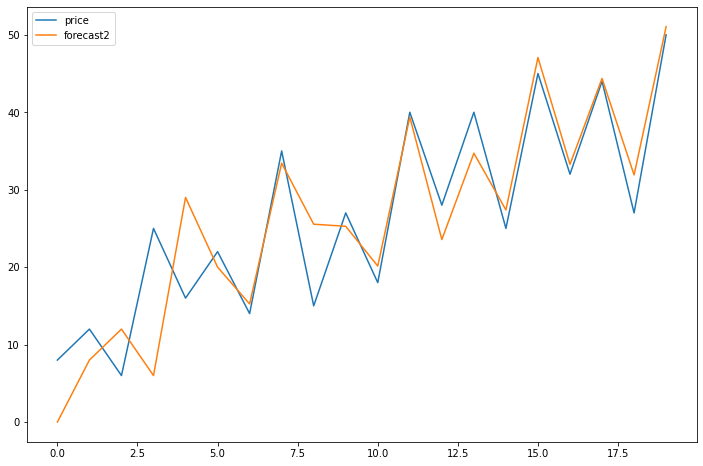

In [27]:
series['forecast2'] = results.predict()
series[['price','forecast2']].plot(figsize=(12,8))


In [31]:
series

,qtr,t,price,Price First Difference,forecast,Price Second Difference,forecast2
0,10 Q1,1,8,NaN,NaN,NaN,0.000000
1,10 Q2,2,12,4.0,NaN,NaN,7.999970
2,10 Q3,3,6,-6.0,0.103923,-2.0,11.999963
3,10 Q4,4,25,19.0,8.155884,13.0,6.000048
4,11 Q1,5,16,-9.0,-13.181759,10.0,28.999904
5,11 Q2,6,22,6.0,0.424321,-3.0,20.000101
6,11 Q3,7,14,-8.0,-4.311586,-2.0,15.248866
7,11 Q4,8,35,21.0,10.181940,13.0,33.423795
8,12 Q1,9,15,-20.0,-17.317303,1.0,25.543343
9,12 Q2,10,27,12.0,12.685896,-8.0,25.271215


### We can see that SARIMAX model gives much better fit than ARIMA model for the forecast of price because of seasonality in the data and SARIMAX is more suitable to handle seasonal data 